In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from compress_pickle import dump, load
from math import log
from statistics import median, mean
from scipy.stats import kstest
path = './files/'

plt.style.use('bmh')


def open_pickle(file):
    with open(path+file, 'rb') as pickle_file:
        return load(path=pickle_file, compression='infer')

THINGS TO LOOK INTO:
- Some gene sets have 0 genes - not mapped?
- Some gene sets have the same genes - probably also a result of mapping, should I make them into one?=

In [23]:
# import clustering results
# /clustering_results/leiden_2_15_0001_05_msigdb_c2_cgp.gz
# /clustering_results/leiden_2_15_0001_05_msigdb_c3_cgp.gz
# /clustering_results/leiden_2_15_0001_05_msigdb_c6_cgp.gz

# msigdb_c2_cgp_clust = open_pickle('clustering_results/leiden_2_15_0001_05_msigdb_c2_cgp.gz')
msigdb_c3_tft_clust = open_pickle('clustering_results/leiden_2_15_0001_05_msigdb_c3_tft_filtered.gz')
# msigdb_c6_all_clust = open_pickle('clustering_results/leiden_2_15_0001_05_msigdb_c6_all.gz')

In [4]:
threshold = 0.05

def get_cluster_distributions(clust_df, filt=False):
    distributions = pd.DataFrame()
    for (res, betas) in clust_df.items():
        for (beta, cluster_enrichments) in betas.items():
            if filt:
                cluster_sizes = [float(log(cluster[1], 10)) for cluster in cluster_enrichments[0].values() if ((cluster[0]['FDR'] < threshold).any())]
            else:
                cluster_sizes = [float(log(cluster[1], 10)) for cluster in cluster_enrichments[0].values() if cluster[1] > 1]
                
            n_clusters = len(cluster_sizes)
            distributions = pd.concat([distributions, pd.DataFrame({'size': cluster_sizes, 'resolution':[res]*n_clusters, 'beta': [beta]*n_clusters})])
    return distributions

to_get = msigdb_c3_tft_clust
distributions_df = get_cluster_distributions(to_get, filt=False)
distributions_df_filt = get_cluster_distributions(to_get, filt=True)

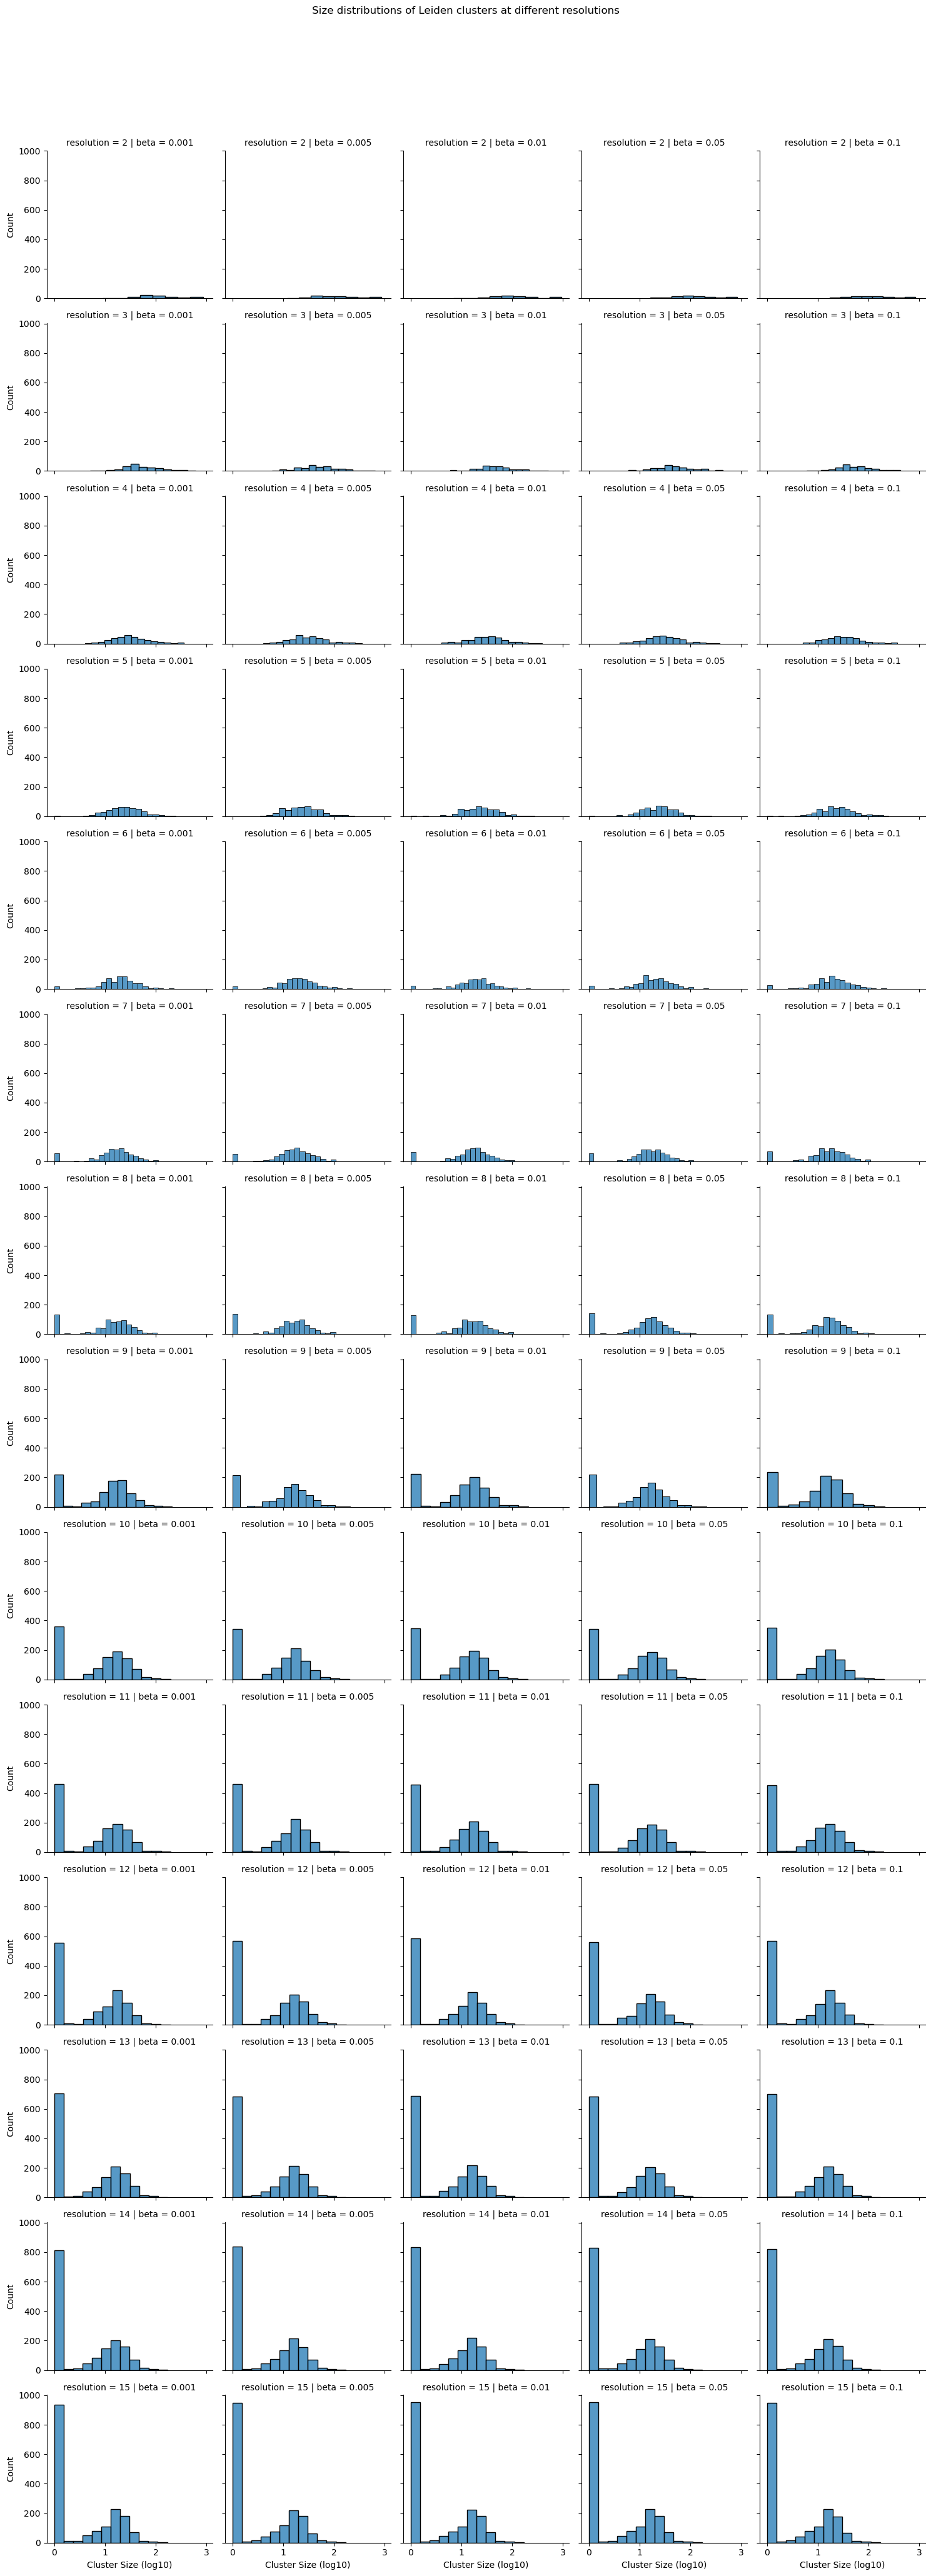

In [55]:
fig1 = sns.FacetGrid(distributions_df, row='resolution',col='beta')
fig1.map(sns.histplot, 'size')
fig1.figure.suptitle("Size distributions of Leiden clusters at different resolutions")
fig1.figure.subplots_adjust(top=0.925)
fig1.set_xlabels('Cluster Size (log10)')
for ax in fig1.axes.flat:
    ax.text(0.85, 0.85, ax)

# fig2 = sns.FacetGrid(distributions_df_filt, row='resolution',col='beta')
# fig2.map(sns.histplot, 'size')
# fig2.figure.suptitle("Size distributions of Leiden clusters at different resolutions")
# fig2.figure.subplots_adjust(top=0.925)
# fig2.set_xlabels('Cluster Size (log10)')

#fig.savefig('./images/grid_leiden_2_5_001_05_msigdbcgp.png')

In [ ]:
from scipy.stats import kstest

base = msigdb
base_distribution = [log(len(gene_set), 10) for gene_set in base.values() if len(gene_set) != 0] 
ks_test_results_df = pd.DataFrame()
distribution = distributions_df
for res in distribution['resolution'].unique():
    for beta in distribution['beta'].unique():
        sizes = distribution[((distribution['resolution'] == res) & (distribution['beta'] == beta))]['size']
        test_p = kstest(sizes, base_distribution).pvalue
        ks_test_results_df = pd.concat([ks_test_results_df, pd.DataFrame({'resolution': [res], 'beta': [beta], 'p_value': [test_p]})])

print(ks_test_results_df[ks_test_results_df['pvalue'] > 0.05])

Empty DataFrame
Columns: [resolution, beta, p_value]
Index: []


435.99999999999983
1.0


Text(0.5, 23.52222222222222, 'Cluster Size (log10)')

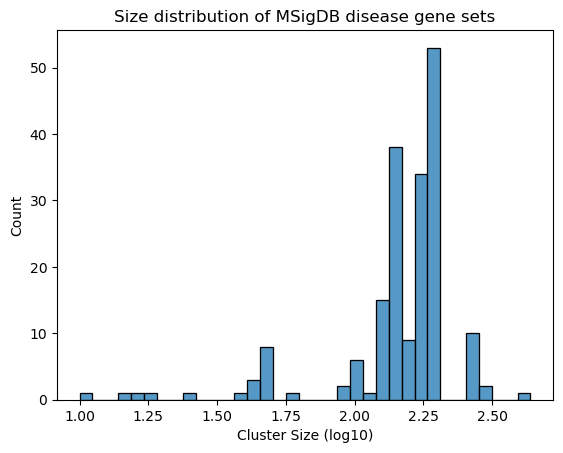

In [ ]:
set_sizes = [log(len(gene_set), 10) for gene_set in msigdb_c6_dict.values() if len(gene_set) != 0] 
fig = sns.histplot(set_sizes)
fig.set_title("Size distribution of MSigDB disease gene sets")
fig.get_figure().savefig("helloo.png")
fig.set_xlabel("Cluster Size (log10)")

In [26]:

threshold = 0.01

def calculate_CCS(enrichment_dict, threshold=0.05):
    CCS_df = pd.DataFrame()
    for (res, betas) in enrichment_dict.items():
        for (beta, cluster_enrichments) in betas.items():
            enriched = list()
            cluster_sizes = list()
            for cluster in cluster_enrichments[0].values():
                cluster_sizes.append(cluster[1])
                cluster=cluster[0]
                enriched_paths = cluster[cluster['FDR'] < threshold]
                if enriched_paths.empty:
                    continue
                enriched.append(enriched_paths[:][['pathway_id', 'FDR']])


            # enriched = [cluster[0][cluster[0]['FDR'] < threshold] for cluster in cluster_enrichments[0].values()]
            n_enriched_clusters = len(enriched)
            if n_enriched_clusters == 0:
                CCS_df = pd.concat([CCS_df, pd.DataFrame({'resolution': [res], 'beta': [beta], 'CCS': [0]})])
                continue
            enriched_df = pd.concat(enriched)
            avg_set_per_cluster = len(enriched_df) / n_enriched_clusters
            avg_cluster_per_set = enriched_df.groupby('pathway_id')['pathway_id'].count().mean()
            CCS = avg_set_per_cluster / avg_cluster_per_set
            CCS_df = pd.concat([CCS_df, pd.DataFrame({'resolution': [res],
                                                      'beta': [beta],
                                                      'n_nodes': sum(cluster_sizes),
                                                      'n_clusters': len(cluster_enrichments[0]),
                                                      'avg_size': mean(cluster_sizes),
                                                      'median_size': median(cluster_sizes),
                                                      'n_enriched': n_enriched_clusters ,
                                                      'avg_s/c': avg_set_per_cluster,
                                                      'avg_c/s':avg_cluster_per_set,
                                                      'CCS': [CCS]})])
    return CCS_df
            

CCSs = calculate_CCS(msigdb_c3_tft_clust)

In [27]:
CCSs['Error'] = CCSs['avg_s/c'] + CCSs['avg_c/s'] - 2
CCSs['%enriched'] = CCSs['n_enriched'] / CCSs['n_clusters'] * 100

CCSs[CCSs['beta'] == 0.05].sort_values('resolution')

,resolution,beta,n_nodes,n_clusters,avg_size,median_size,n_enriched,avg_s/c,avg_c/s,CCS,Error,%enriched
0,2,0.05,4142,50,82.840000,67.0,17,10.411765,1.141935,9.117647,9.553700,34.000000
0,3,0.05,10278,183,56.163934,41.0,44,9.090909,1.398601,6.500000,8.489510,24.043716
0,4,0.05,12673,316,40.104430,29.0,58,8.017241,1.544850,5.189655,7.562092,18.354430
0,5,0.05,14227,430,33.086047,24.0,66,6.621212,1.496575,4.424242,6.117787,15.348837
0,6,0.05,14335,534,26.844569,20.0,62,4.790323,1.394366,3.435484,4.184689,11.610487
0,7,0.05,14506,594,24.420875,19.0,64,4.937500,1.556650,3.171875,4.494150,10.774411
0,8,0.05,14642,634,23.094637,18.0,60,3.900000,1.453416,2.683333,3.353416,9.463722
0,9,0.05,14546,660,22.039394,17.0,62,3.645161,1.477124,2.467742,3.122285,9.393939
0,10,0.05,14643,681,21.502203,17.0,65,3.969231,1.500000,2.646154,3.469231,9.544787
0,11,0.05,14504,691,20.989870,17.0,59,3.677966,1.364780,2.694915,3.042746,8.538350


684


<Axes: ylabel='Count'>

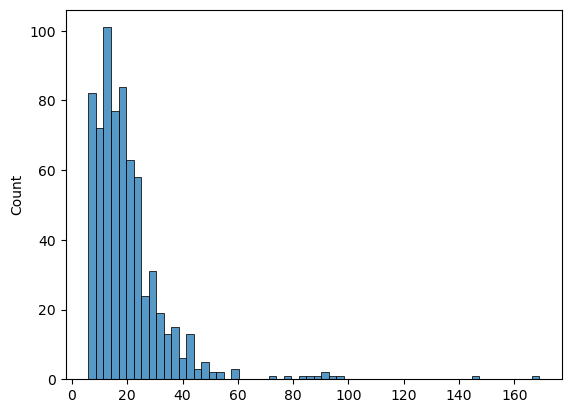

In [68]:
sizes = [len(cluster[2]) for cluster in msigdb_c3_tft_clust[15][0.01][0].values()]
print(len([size for size in sizes if size > 5]))
sns.histplot([size for size in sizes if size > 5])

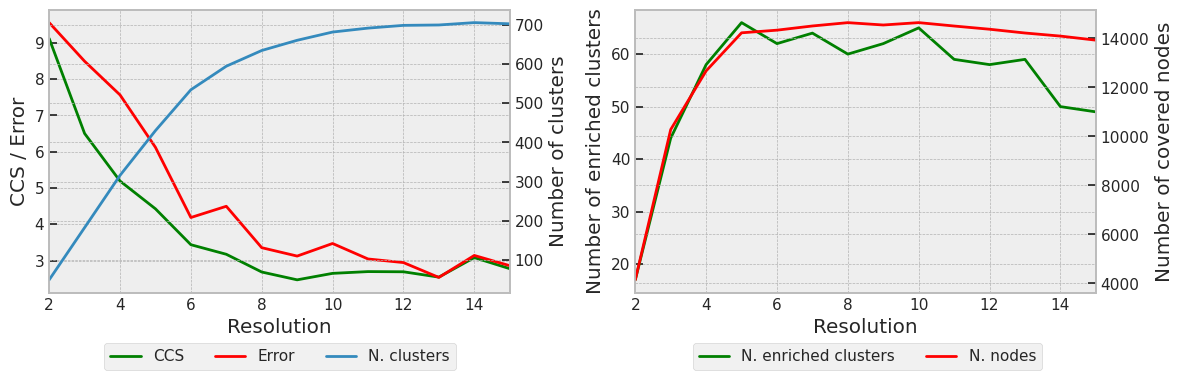

In [59]:
import numpy as np
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
sns.set_theme(palette='tab20')
plt.style.use('bmh')


beta = 0.05

beta_05_CCS = {row[1]['resolution'] : row[1]['CCS'] for row in CCSs.iterrows() if row[1]['beta'] == beta}
beta_05_n = {row[1]['resolution'] : row[1]['n_clusters'] for row in CCSs.iterrows() if row[1]['beta'] == beta}
beta_05_error = {row[1]['resolution'] : row[1]['Error'] for row in CCSs.iterrows() if row[1]['beta'] == beta}
beta_05_enriched = {row[1]['resolution'] : row[1]['n_enriched'] for row in CCSs.iterrows() if row[1]['beta'] == beta}
beta_05_nodes = {row[1]['resolution'] : row[1]['n_nodes'] for row in CCSs.iterrows() if row[1]['beta'] == beta}


line1 = ax1.plot(beta_05_CCS.keys(), beta_05_CCS.values(), c='g', label="CCS")
line2 = ax1.plot(beta_05_error.keys(), beta_05_error.values(), c='r', label="Error")

ax1.set_xlabel("Resolution")
ax1.set_ylabel("CCS / Error")

ax1.set_xlim([2, 15])
ax12 = ax1.twinx()
line3 = ax12.plot(beta_05_CCS.keys(), beta_05_n.values(), label="N. clusters")
ax12.set_ylabel("Number of clusters")

lines = line1+line2+line3
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, bbox_to_anchor=(0.9, -0.15), ncol=3)

ax2.set_xlim([2, 15])
line4 = ax2.plot(beta_05_enriched.keys(), beta_05_enriched.values(), c='g', label="N. enriched clusters")
ax2.set_ylabel("Number of enriched clusters")

ax22 = ax2.twinx()
line5 = ax22.plot(beta_05_nodes.keys(), beta_05_nodes.values(), c='r', label="N. nodes")
ax22.set_ylabel("Number of covered nodes")
ax2.set_xlabel("Resolution")

lines2 = line4+line5
labels = [line.get_label() for line in lines2]
ax2.legend(lines, labels, bbox_to_anchor=(0.9, -0.15), ncol=2)

fig.tight_layout()

plt.savefig("test.png", dpi=1000)

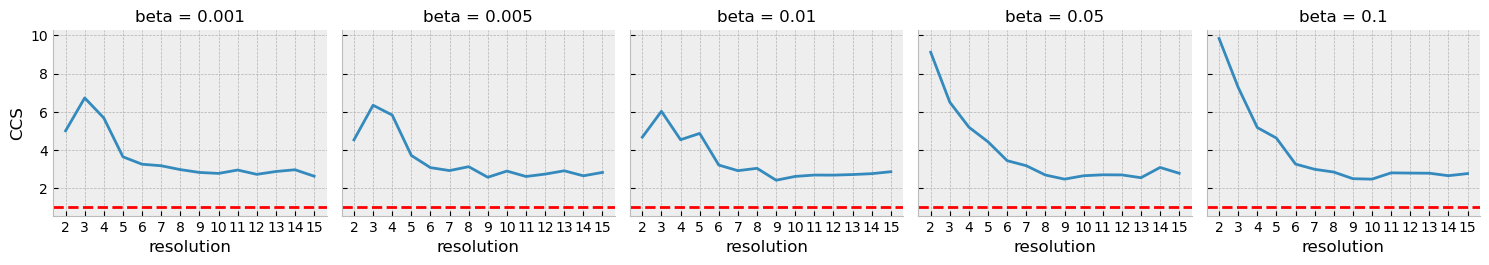

In [19]:
fig = sns.FacetGrid(CCSs, col='beta')
fig.map(sns.lineplot, 'resolution', 'CCS')
fig.set(xticks=CCSs['resolution'].unique())
# fig.set(ybound=[0,3])
fig.refline(y=1, color='red')
fig.fig.subplots_adjust(top=0.8)

fig.savefig('betas.png', dpi =1000)

In [4]:
# msigdb_c2_cgp_dict = open_pickle('msigdb_c2_cgp_dict.pkl')
msigdb_c3_tft_dict = open_pickle('msigdb_c3_tft_dict.pkl')

In [5]:
gene_sets = pd.Series([len(set(gene_set)) for gene_set in msigdb_c3_tft_dict.values()])

gene_sets.where(gene_sets == 0).dropna()

82     0.0
152    0.0
282    0.0
dtype: float64

In [6]:
# 
from itertools import combinations

gene_sets = pd.Series([set(gene_set) for gene_set in msigdb_c3_tft_dict.values()])  # some gene sets have no mapping aka have 0 genes
overlap_coefficients = list()

for i in range(len(gene_sets)-1):
    for j in range(i+1, len(gene_sets)):
        set_A = gene_sets[i]
        set_B = gene_sets[j]
        # if set_A == set_B:
        #     print(i)
        #     print(j)
        if len(set_A) == 0 or len(set_B) == 0: # tft 3 sets with 0
            continue
        ov_coeff = (len(set_A.intersection(set_B)))/(min(len(set_A), len(set_B)))
        overlap_coefficients.append(ov_coeff)

jaccard = list()
for set_A, set_B in combinations(gene_sets, 2):
    if len(set_A) == 0 or len(set_B) == 0: # tft 3 sets with 0
        continue
    jacc = len(set_A.intersection(set_B))/len(set_A.union(set_B))
    jaccard.append(jacc)
len(jaccard) == len(overlap_coefficients)

True

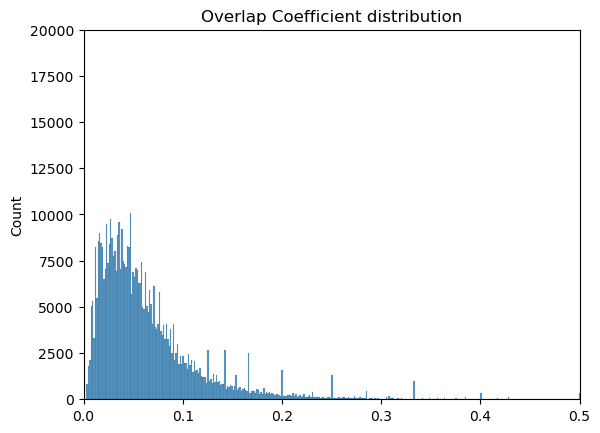

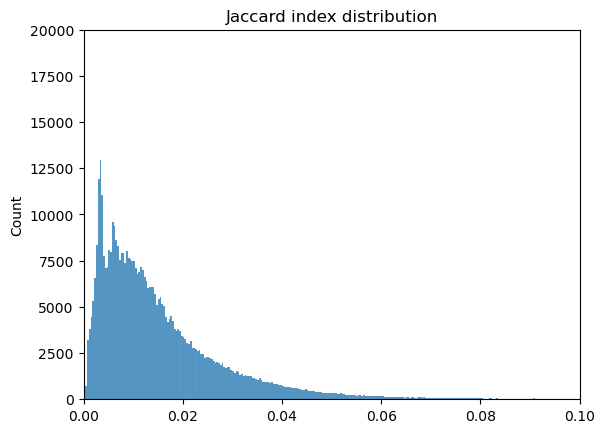

In [76]:

fig1 = sns.histplot(overlap_coefficients)
fig1.set_ylim([0, 20000])
fig1.set_xlim([0, 0.5])
fig1.set_title("Overlap Coefficient distribution")


# fig2 = sns.histplot(jaccard)
# fig2.set_title("Jaccard index distribution")
# fig2.set_ylim([0, 20000])
# fig2.set_xlim([0, 0.1])
# plt.show()

18126
821
15.0


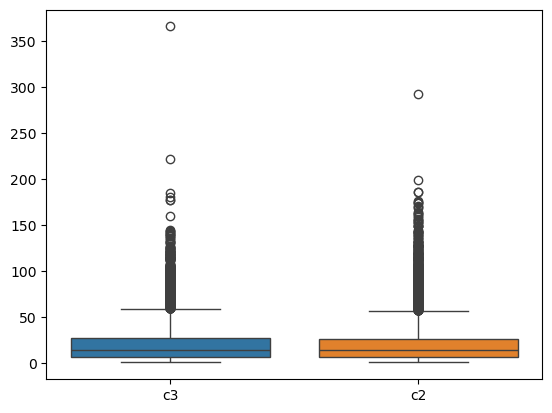

In [32]:
# investigate dataset overlap - number of times that each gene appears in all gene sets
import matplotlib.pyplot as plt


genes = pd.Series([str(gene) for gene_set in msigdb_c3_tft_dict.values() for gene in gene_set])
gene_freqs = genes.value_counts(normalize=False)
genes = pd.Series([str(gene) for gene_set in msigdb_c2_cgp_dict.values() for gene in gene_set])
gene_freqs2 = genes.value_counts(normalize=False)



fig = sns.boxplot(pd.DataFrame({'c3': gene_freqs, 'c2': gene_freqs2}))

upper_c3 = gene_freqs.mean() + 2*gene_freqs.std()
print(len(gene_freqs))
print(len(gene_freqs.where(gene_freqs > upper_c3).dropna()))
print(gene_freqs.median())